## Clustering jobs

In [1]:
# 1. Imports & Paths
import importlib.util

import os, sys, re, pandas as pd
sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data")
resume_path = os.path.join(DATA_DIR, "resumes_cleaned.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_cleaned.csv")

SAVE_DIR = os.path.join(os.pardir, "data/clusters")

EMB_DIR = os.path.join(os.pardir, "data/embeddings")
remb_path = os.path.join(EMB_DIR, "resume_embeddings.npy")
jemb_path   = os.path.join(EMB_DIR, "job_embeddings.npy")

In [83]:
%load_ext autoreload
%autoreload 2
from utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# # 7clustering.ipynb — Resume–Job Domain Alignment + Visualization + Matching

# # =============================================
# # 1️⃣ Imports & Paths
# # =============================================
# import os, sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import cosine_similarity



# Define paths
DATA_DIR = os.path.join(os.pardir, 'data')
EMB_DIR = os.path.join(DATA_DIR, 'embeddings')

resume_path = os.path.join(DATA_DIR, 'resumes_clustered.csv')
jobs_path   = os.path.join(DATA_DIR, 'jobs_cleaned.csv')
remb_path   = os.path.join(EMB_DIR, 'resume_embeddings.npy')
jemb_path   = os.path.join(EMB_DIR, 'job_embeddings.npy')

# # =============================================
# # 2️⃣ Load Data and Embeddings
# # =============================================
resumes = pd.read_csv(resume_path)
jobs = pd.read_csv(jobs_path)

resume_emb = np.load(remb_path)
job_emb = np.load(jemb_path)

# print(f"Loaded {len(resumes)} resumes and {len(jobs)} job posts.")

# # =============================================
# # 3️⃣ K-Means Clustering for Job Embeddings
# # =============================================
# n_clusters = 12
# job_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# jobs['PredictedCluster'] = job_kmeans.fit_predict(job_emb)

# # =============================================
# # 4️⃣ Keyword-Based Domain Labeling for Jobs
# # =============================================
# # def infer_keyword_domain(text, keywords_dict):
# #     text = str(text).lower()
# #     scores = {domain: sum(kw in text for kw in kws) for domain, kws in keywords_dict.items()}
# #     return max(scores, key=scores.get) if scores else 'Unknown'

# jobs['KeywordDomain'] = jobs['job_text_clean'].apply(lambda t: infer_keyword_domain(t, DOMAIN_KEYWORDS_REFERENCE))

# # Assign cluster-level domain labels
# cluster_labels = {}
# for cid, group in jobs.groupby('PredictedCluster'):
#     top_label = group['KeywordDomain'].value_counts().idxmax()
#     cluster_labels[cid] = top_label

# jobs['JobClusterDomainLabel'] = jobs['PredictedCluster'].map(cluster_labels)

# # =============================================
# # 5️⃣ Compute Cross-Domain Similarity
# # =============================================
# resume_domains = resumes['ClusterDomainLabel'].unique()
# job_domains = jobs['JobClusterDomainLabel'].unique()

# resume_centroids = []
# for domain in resume_domains:
#     cluster_vectors = resume_emb[resumes['ClusterDomainLabel'] == domain]
#     resume_centroids.append(cluster_vectors.mean(axis=0))

# job_centroids = []
# for domain in job_domains:
#     cluster_vectors = job_emb[jobs['JobClusterDomainLabel'] == domain]
#     job_centroids.append(cluster_vectors.mean(axis=0))

# similarity = cosine_similarity(resume_centroids, job_centroids)

# # =============================================
# # 6️⃣ Visualize Cross-Domain Alignment (Heatmap)
# # =============================================
# plt.figure(figsize=(10,7))
# sns.heatmap(similarity, annot=True, fmt='.2f', cmap='YlGnBu',
#             xticklabels=job_domains, yticklabels=resume_domains)
# plt.title('Resume–Job Domain Similarity (Cosine)')
# plt.xlabel('Job Domains')
# plt.ylabel('Resume Domains')
# plt.show()

# # =============================================
# # 7️⃣ Visualization: Top 3 Matches per Resume Domain (Bar Chart)
# # =============================================
# summary_data = []
# for i, resume_domain in enumerate(resume_domains):
#     sims = similarity[i]
#     sorted_idx = np.argsort(sims)[::-1][:3]
#     top_matches = [(job_domains[j], sims[j]) for j in sorted_idx]
#     for job_dom, score in top_matches:
#         summary_data.append((resume_domain, job_dom, score))

# summary_df = pd.DataFrame(summary_data, columns=['ResumeDomain', 'JobDomain', 'Similarity'])

# plt.figure(figsize=(10,6))
# sns.barplot(data=summary_df, x='ResumeDomain', y='Similarity', hue='JobDomain', palette='Set2')
# plt.title('Top 3 Matching Job Domains for Each Resume Domain')
# plt.ylabel('Cosine Similarity')
# plt.ylim(0.6, 1.0)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

# # =============================================
# # 8️⃣ Text Summary of Domain Alignment
# # =============================================
# for i, resume_domain in enumerate(resume_domains):
#     top_idx = np.argmax(similarity[i])
#     best_match = job_domains[top_idx]
#     score = similarity[i, top_idx]
#     second_idx = np.argsort(similarity[i])[-2]
#     second_best = job_domains[second_idx]
#     second_score = similarity[i, second_idx]
#     print(f"{resume_domain} resumes best match {best_match} jobs (similarity={score:.3f}), followed by {second_best} ({second_score:.3f}).")

# # =============================================
# # 9️⃣ Individual Resume→Job Matching
# # =============================================
# # For each resume vector, find the closest job cluster centroid
# resume_to_job = []
# for idx, vec in enumerate(resume_emb):
#     sims = cosine_similarity([vec], job_centroids)[0]
#     top_idx = np.argmax(sims)
#     best_job_domain = job_domains[top_idx]
#     score = sims[top_idx]
#     resume_to_job.append((idx, resumes.loc[idx, 'ClusterDomainLabel'], best_job_domain, score))

# match_df = pd.DataFrame(resume_to_job, columns=['ResumeIndex', 'ResumeDomain', 'MatchedJobDomain', 'Similarity'])

# # Save the mapping
# match_out_path = os.path.join(DATA_DIR, 'resume_job_matches.csv')
# match_df.to_csv(match_out_path, index=False)
# print(f'✅ Saved individual resume→job domain matches to {match_out_path}')

# # =============================================
# # 🔚 Summary
# # =============================================
# print("\nPipeline complete:")
# print("1. Generated job domain clusters.")
# print("2. Compared resume↔job semantic centroids (heatmap + bar chart).")
# print("3. Saved per-resume best job domain matches for future analysis.")

In [85]:
# # 7clustering.ipynb — Job Domain Clustering and Labeling

# # =============================================
# # 1️⃣ Imports & Paths
# # =============================================
# import os, sys
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans

# # Define paths
# DATA_DIR = os.path.join(os.pardir, 'data')
# EMB_DIR = os.path.join(DATA_DIR, 'embeddings')

# jobs_path = os.path.join(DATA_DIR, 'jobs_cleaned.csv')
# jemb_path = os.path.join(EMB_DIR, 'job_embeddings.npy')

# # =============================================
# # 2️⃣ Load Data and Embeddings
# # =============================================
# jobs = pd.read_csv(jobs_path)
# job_emb = np.load(jemb_path)

# print(f"Loaded {len(jobs)} job postings with {job_emb.shape[1]}-D embeddings.")

# # =============================================
# # 3️⃣ K-Means Clustering for Job Embeddings
# # =============================================
# n_clusters = 12
# job_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# jobs['PredictedCluster'] = job_kmeans.fit_predict(job_emb)

# # =============================================
# # 4️⃣ Keyword-Based Domain Labeling for Jobs
# # =============================================
# # Use shared dictionary for both resumes and jobs
# # Make sure DOMAIN_KEYWORDS_REFERENCE is imported from utils or defined above

# def infer_keyword_domain(text, keywords_dict):
#     text = str(text).lower()
#     scores = {domain: sum(kw in text for kw in kws) for domain, kws in keywords_dict.items()}
#     return max(scores, key=scores.get) if scores else 'Unknown'

# # Assign a keyword-based domain label to each job
# jobs['KeywordDomain'] = jobs['job_text_clean'].apply(lambda t: infer_keyword_domain(t, DOMAIN_KEYWORDS_REFERENCE))

# # Assign cluster-level dominant domain labels
# cluster_labels = {}
# for cid, group in jobs.groupby('PredictedCluster'):
#     top_label = group['KeywordDomain'].value_counts().idxmax()
#     cluster_labels[cid] = top_label

# jobs['ClusterDomainLabel'] = jobs['PredictedCluster'].map(cluster_labels)

# # Add a DomainCluster column for structural consistency with resumes
# jobs['DomainCluster'] = jobs['KeywordDomain']

# # =============================================
# # 5️⃣ Save Clustered Job Dataset
# # =============================================
# out_path = os.path.join(DATA_DIR, 'jobs_clustered.csv')
# jobs.to_csv(out_path, index=False)
# print(f'✅ Saved clustered job dataset to {out_path}')

# # =============================================
# # 🔚 Summary
# # =============================================
# print("\nPipeline complete:")
# print("1. Clustered job embeddings into 12 groups.")
# print("2. Added KeywordDomain, ClusterDomainLabel, and DomainCluster columns.")
# print("3. Saved jobs_clustered.csv for downstream matching.")


✅ Combined feature matrix shape: (5448, 396)


100%|██████████| 12/12 [00:01<00:00,  6.48it/s]


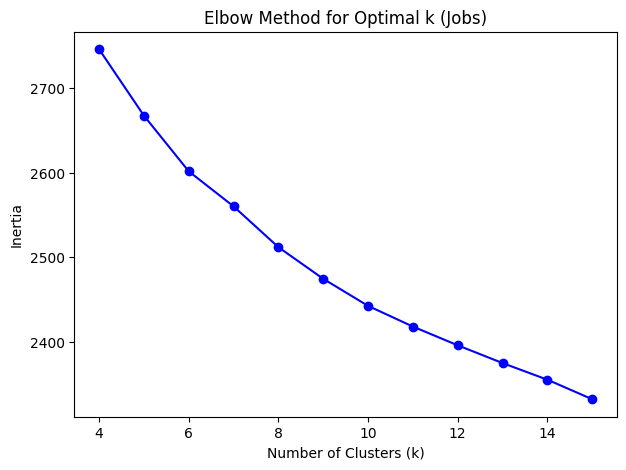

/var/folders/d1/yqpl2qxj4cz5f4m9dtq22gs80000gn/T/ipykernel_85716/1711188454.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_labels = jobs.groupby("PredictedCluster", group_keys=False).apply(weighted_cluster_label)


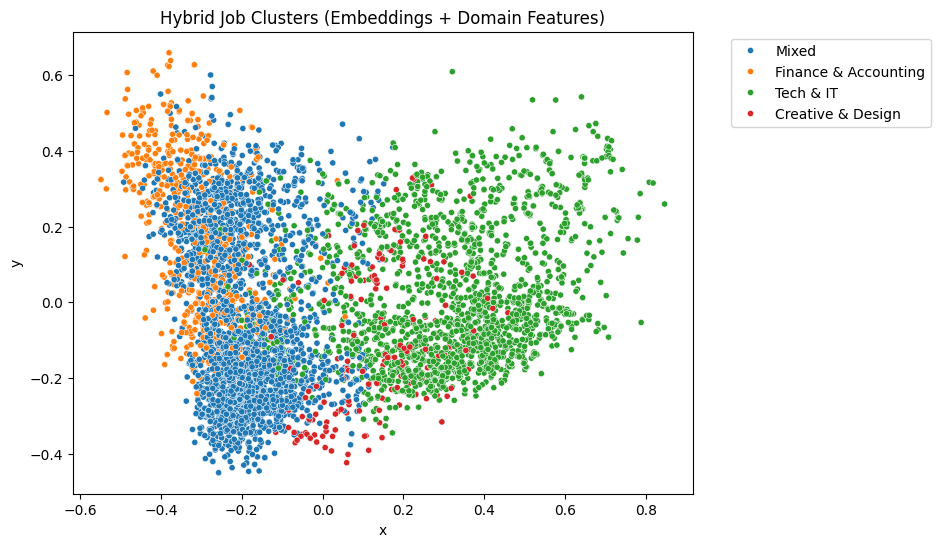

Adjusted Rand Index (vs true Domain): 0.184
Silhouette Score: 0.054
    PredictedCluster    ClusterDomainLabel  Count
1                  1                 Mixed    804
0                  0             Tech & IT    739
6                  6                 Mixed    659
4                  4             Tech & IT    539
9                  9             Tech & IT    511
8                  8                 Mixed    434
7                  7                 Mixed    410
3                  3  Finance & Accounting    324
2                  2             Tech & IT    316
10                10  Finance & Accounting    312
11                11                 Mixed    227
5                  5     Creative & Design    173

ClusterDomainLabel Distribution:
ClusterDomainLabel
Mixed                   2534
Tech & IT               2105
Finance & Accounting     636
Creative & Design        173
Name: count, dtype: int64

✅ Saved improved clustered job dataset → ../data/jobs_clustered.csv
Unique domain labe

In [86]:
# =============================================
# 3️⃣ Compute Domain Keyword Vectors
# =============================================
from sklearn.metrics import silhouette_score, adjusted_rand_score

def domain_score_vector(text, domain_keywords=DOMAIN_KEYWORDS_REFERENCE):
    """Count occurrences of each domain keyword in a text."""
    text_lower = str(text).lower()
    return {
        domain: sum(kw in text_lower for kw in keywords)
        for domain, keywords in domain_keywords.items()
    }

job_domain_vectors = [domain_score_vector(t) for t in jobs["job_text_clean"]]
job_domain_df = pd.DataFrame(job_domain_vectors, index=jobs.index)

# Normalize keyword scores (important for hybrid features)
scaler = MinMaxScaler()
job_domain_scaled = scaler.fit_transform(job_domain_df)

# Combine embeddings with normalized domain features
job_features = np.hstack([job_emb, job_domain_scaled])
print(f"✅ Combined feature matrix shape: {job_features.shape}")

# =============================================
# 4️⃣ Optimal Cluster Selection (Elbow Method)
# =============================================
from tqdm import tqdm
inertias = []
K = range(4, 16)

for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(job_features)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k (Jobs)")
plt.show()

# Based on elbow, we’ll stay consistent with resumes
n_clusters = 12
job_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
jobs["PredictedCluster"] = job_kmeans.fit_predict(job_features)

# =============================================
# 5️⃣ Keyword-Based Domain Labeling
# =============================================
def infer_keyword_domain(text, keywords_dict=DOMAIN_KEYWORDS_REFERENCE):
    text = str(text).lower()
    scores = {domain: sum(kw in text for kw in kws) for domain, kws in keywords_dict.items()}
    return max(scores, key=scores.get) if any(scores.values()) else "Other Services"

jobs["KeywordDomain"] = jobs["job_text_clean"].apply(infer_keyword_domain)

# Weighted cluster-level labeling
def weighted_cluster_label(group):
    label_counts = group["KeywordDomain"].value_counts(normalize=True)
    top_label = label_counts.index[0]
    top_share = label_counts.iloc[0]
    return top_label if top_share >= 0.4 else "Mixed"

cluster_labels = jobs.groupby("PredictedCluster", group_keys=False).apply(weighted_cluster_label)
cluster_labels = cluster_labels.reset_index().rename(columns={0: "ClusterDomainLabel"})
label_map = dict(zip(cluster_labels["PredictedCluster"], cluster_labels["ClusterDomainLabel"]))
jobs["ClusterDomainLabel"] = jobs["PredictedCluster"].map(label_map)

# Add consistency column
jobs["DomainCluster"] = jobs["KeywordDomain"]

# =============================================
# 6️⃣ PCA Visualization (2D)
# =============================================
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(job_features)
jobs["x"], jobs["y"] = reduced[:,0], reduced[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x="x", y="y", hue="ClusterDomainLabel", data=jobs, palette="tab10", s=20)
plt.title("Hybrid Job Clusters (Embeddings + Domain Features)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# =============================================
# 7️⃣ Evaluation Metrics
# =============================================
# Optional: if jobs had a ground-truth domain column like resumes['DomainCluster']
if "DomainCluster" in jobs.columns:
    ari = adjusted_rand_score(jobs["DomainCluster"], jobs["PredictedCluster"])
    print(f"Adjusted Rand Index (vs true Domain): {ari:.3f}")
else:
    print("Adjusted Rand Index skipped (no ground-truth domain labels for jobs).")

sil = silhouette_score(job_features, jobs["PredictedCluster"])
print(f"Silhouette Score: {sil:.3f}")

# =============================================
# 8️⃣ Cluster Summary
# =============================================
summary = jobs.groupby(["PredictedCluster", "ClusterDomainLabel"]).size().reset_index(name="Count")
print(summary.sort_values("Count", ascending=False))
print("\nClusterDomainLabel Distribution:")
print(jobs["ClusterDomainLabel"].value_counts())

# =============================================
# 9️⃣ Save Updated Clustered Dataset
# =============================================
out_path = os.path.join(SAVE_DIR, "jobs_clustered.csv")
jobs.to_csv(out_path, index=False)
print(f"\n✅ Saved improved clustered job dataset → {out_path}")
print(f"Unique domain labels: {sorted(jobs['ClusterDomainLabel'].unique())}")

In [87]:
mixed_jobs = jobs[jobs["ClusterDomainLabel"] == "Mixed"].copy()
print(f"🔍 Mixed subset size: {len(mixed_jobs)}")
mixed_domain_vectors = [domain_score_vector(t) for t in mixed_jobs["job_text_clean"]]
mixed_domain_df = pd.DataFrame(mixed_domain_vectors, index=mixed_jobs.index)

mixed_scaled = scaler.fit_transform(mixed_domain_df)
mixed_features = np.hstack([job_emb[mixed_jobs.index], mixed_scaled])
print(f"Mixed feature matrix shape: {mixed_features.shape}")
remaining_domains = [
    "Education", "HR & Operations", "Healthcare",
    "Hospitality & Food", "Manufacturing & Construction", "Other Services"
]
from sklearn.cluster import KMeans

k_recluster = 6  # matching the number of remaining domains
mixed_kmeans = KMeans(n_clusters=k_recluster, random_state=42, n_init="auto")
mixed_jobs["PredictedSubcluster"] = mixed_kmeans.fit_predict(mixed_features)
def infer_secondary_domain(text):
    text = str(text).lower()
    scores = {d: sum(kw in text for kw in DOMAIN_KEYWORDS_REFERENCE[d])
              for d in remaining_domains}
    return max(scores, key=scores.get) if any(scores.values()) else "Other Services"

mixed_jobs["KeywordDomain"] = mixed_jobs["job_text_clean"].apply(infer_secondary_domain)

# Weighted labeling (same logic as before)
def weighted_label(group):
    counts = group["KeywordDomain"].value_counts(normalize=True)
    top_label, share = counts.index[0], counts.iloc[0]
    return top_label if share >= 0.4 else "Mixed"

subcluster_labels = mixed_jobs.groupby("PredictedSubcluster", group_keys=False).apply(weighted_label)
label_map = dict(zip(subcluster_labels.index, subcluster_labels.values))
mixed_jobs["SubclusterDomainLabel"] = mixed_jobs["PredictedSubcluster"].map(label_map)
# Update original job dataframe
jobs.loc[mixed_jobs.index, "ClusterDomainLabel"] = mixed_jobs["SubclusterDomainLabel"]
print("\n🔹 Updated ClusterDomainLabel Distribution:")
print(jobs["ClusterDomainLabel"].value_counts())

sil_total = silhouette_score(job_features, job_kmeans.labels_)
print(f"Original Silhouette: {sil:.3f}, After recluster (approx): {sil_total:.3f}")

out_path = os.path.join(SAVE_DIR, "jobs_reclustered.csv")
jobs.to_csv(out_path, index=False)
print(f"✅ Saved reclustered job dataset → {out_path}")



🔍 Mixed subset size: 2534


Mixed feature matrix shape: (2534, 396)


/var/folders/d1/yqpl2qxj4cz5f4m9dtq22gs80000gn/T/ipykernel_85716/3050566070.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subcluster_labels = mixed_jobs.groupby("PredictedSubcluster", group_keys=False).apply(weighted_label)



🔹 Updated ClusterDomainLabel Distribution:
ClusterDomainLabel
Tech & IT               2105
Other Services          1076
Mixed                    798
Education                660
Finance & Accounting     636
Creative & Design        173
Name: count, dtype: int64
Original Silhouette: 0.054, After recluster (approx): 0.054
✅ Saved reclustered job dataset → ../data/jobs_reclustered.csv


In [88]:
mixed_remaining = jobs[jobs["ClusterDomainLabel"] == "Mixed"]
mixed_remaining.sample(5)[["Title", "JobDescription", "KeywordDomain"]]


,Title,JobDescription,KeywordDomain
83,Finance and Administrative Director,The Finance and Administrative Director will b...,Healthcare
2918,Exploration Geologist,Fortune Resources LLC is seeking an Exploratio...,Tech & IT
1306,Financial Market Specialist (FMS),The USAID-funded Financial Sector Deepening Pr...,Finance & Accounting
4194,Sales Representative,Energize Global Services CJSC is looking for a...,Tech & IT
3257,Communications Officer,The Communications Officer will be responsible...,Creative & Design


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Use the same hybrid feature set (embeddings + domain features)
X_all = job_features
y_all = jobs["ClusterDomainLabel"]

# Separate labeled vs unlabeled ("Mixed")
mask_labeled = y_all != "Mixed"
mask_unlabeled = y_all == "Mixed"

X_labeled = X_all[mask_labeled]
y_labeled = y_all[mask_labeled]
X_unlabeled = X_all[mask_unlabeled]
le = LabelEncoder()
y_encoded = le.fit_transform(y_labeled)
print("Classes:", list(le.classes_))
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(
    X_labeled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
y_unlabeled_pred = clf.predict(X_unlabeled)
predicted_labels = le.inverse_transform(y_unlabeled_pred)

# Assign back to main dataset
jobs.loc[mask_unlabeled, "ClusterDomainLabel"] = predicted_labels
print("\n✅ Final ClusterDomainLabel Distribution:")
print(jobs["ClusterDomainLabel"].value_counts())

out_path = os.path.join(SAVE_DIR, "jobs_clustered.csv")
jobs.to_csv(out_path, index=False)
print(f"✅ Saved final domain-labeled dataset → {out_path}")


Classes: ['Creative & Design', 'Education', 'Finance & Accounting', 'Other Services', 'Tech & IT']


                      precision    recall  f1-score   support

   Creative & Design       1.00      0.94      0.97        35
           Education       0.96      0.98      0.97       132
Finance & Accounting       0.98      0.99      0.98       127
      Other Services       0.96      0.94      0.95       215
           Tech & IT       0.98      0.98      0.98       421

            accuracy                           0.97       930
           macro avg       0.97      0.97      0.97       930
        weighted avg       0.97      0.97      0.97       930


✅ Final ClusterDomainLabel Distribution:
ClusterDomainLabel
Tech & IT               2251
Other Services          1418
Education                833
Finance & Accounting     772
Creative & Design        174
Name: count, dtype: int64
✅ Saved final domain-labeled dataset → ../data/jobs_final_domains.csv


In [90]:
# matches = pd.read_csv("../data/resume_job_matches.csv")
# matches.head() 

In [91]:
# idx = 0  # change this number to see other examples

# resume_text = resumes.loc[idx, "Resume_clean"]
# resume_domain = matches.loc[idx, "ResumeDomain"]
# job_domain = matches.loc[idx, "MatchedJobDomain"]

# print(f"Resume Domain: {resume_domain}")
# print(f"Matched Job Domain: {job_domain}")
# print("---- Resume ----")
# print(resume_text[:600])  # show first 600 chars


In [92]:
# for domain_name in DOMAIN_KEYWORDS_REFERENCE.keys():
#     keywords = DOMAIN_KEYWORDS_REFERENCE[domain_name]
#     pattern = "|".join([r"\b" + kw + r"\b" for kw in keywords])
#     keyword_matches = jobs[jobs['job_text_clean'].str.contains(pattern, case=False, na=False, regex=True)]

    
#     if not keyword_matches.empty:
#         print(f"\n---- Matching Job Posting for {domain_name} ----")
#         print(keyword_matches.iloc[0]['job_text_clean'][:600])
#     else:
#         print(f"\nNo matching job posting found for {domain_name}")


In [93]:
# # Show top 5 strongest matches overall
# top_matches = match_df.sort_values('Similarity', ascending=False).head(5)

# for _, row in top_matches.iterrows():
#     r_idx = row['ResumeIndex']
#     resume_text = resumes.loc[r_idx, "Resume_clean"][:400]

#     job_domain = row['MatchedJobDomain']
#     job_match = jobs[jobs["JobClusterDomainLabel"] == job_domain].sample(1, random_state=42)
#     job_text = job_match.iloc[0]["job_text_clean"][:400]

#     print(f"\nResume #{r_idx} — {row['ResumeDomain']} → {job_domain} (Similarity: {row['Similarity']:.3f})")
#     print("-" * 90)
#     print("Resume snippet:")
#     print(resume_text)
#     print()
#     print("Matched job posting snippet:")
#     print(job_text)
#     print("=" * 100)


In [94]:
# # =============================================
# # 🔎 Inspect Sample Resume–Job Matches
# # =============================================

# # sample 5 resume–job pairs
# sample = match_df.sample(5, random_state=42)

# for _, row in sample.iterrows():
#     r_idx = row['ResumeIndex']
    
#     # get the resume text
#     resume_text = resumes.loc[r_idx, "Resume_clean"][:400]
    
#     # find a matching job posting in that matched job domain
#     job_domain = row['MatchedJobDomain']
#     job_matches = jobs[jobs["JobClusterDomainLabel"] == job_domain]
    
#     if not job_matches.empty:
#         job_text = job_matches.sample(1, random_state=42).iloc[0]["job_text_clean"][:400]
#     else:
#         job_text = "[No job text found for this domain]"
    
#     print(f"\nResume #{r_idx} — {row['ResumeDomain']} → {job_domain} (Similarity: {row['Similarity']:.3f})")
#     print("-" * 90)
#     print("Resume snippet:")
#     print(resume_text)
#     print()
#     print("Matched job posting snippet:")
#     print(job_text)
#     print("=" * 100)


In [95]:
# print(matches.columns)
